In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [9]:
import util.normalization as norm
import util.model as models
import util.utility as util

In [10]:
df = pd.read_csv("./sample-mcd.csv", encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5 stars
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


# Normalization

In [16]:
df_prc = df[['reviewer_id', 'review']].copy()

# Remove non-ASCII
df_prc['token_sentence'] = df_prc['review'].apply(norm.remove_non_ascii)

# Expand contractions
df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.expand_contractions)

# Remove characters
df_prc['token_sentence'] = df_prc['token_sentence'].apply(norm.remove_characters, args=(True,))

# Remove enter tab
df_prc['token_clean'] = df_prc['token_sentence'].apply(norm.remove_enter_tab)

# Lemmatization
df_prc['token_clean'] = df_prc['token_clean'].apply(norm.lemmatize_text)

In [11]:
# # Tokenization into sentence

# df_st = df[['reviewer_id', 'review']].copy()

# # Sentence Tokenization
# df_st['token_sentence'] = df_st['review'].apply(norm.sentence_tokenize)
# df_st = df_st.explode('token_sentence')
# df_st['token_sentence'] = df_st['token_sentence'].str.strip()

# # Remove non-ASCII
# df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_non_ascii)

# # Expand contractions
# df_st['token_sentence'] = df_st['token_sentence'].apply(norm.expand_contractions)

# # Remove characters
# df_st['token_sentence'] = df_st['token_sentence'].apply(norm.remove_characters, args=(True,))

# # Remove enter tab
# df_st['token_clean'] = df_st['token_sentence'].apply(norm.remove_enter_tab)

# # Lemmatization
# df_st['token_clean'] = df_st['token_clean'].apply(norm.lemmatize_text)

# Get Aspect (Rules Based)

In [17]:
# Get aspect from rules
tqdm.pandas()
df_prc['sub_aspect'] = df_prc['token_clean']\
                        .progress_apply(util.get_aspect_rules)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


In [19]:
print(df_prc.info())
df_prc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer_id     100 non-null    int64 
 1   review          100 non-null    object
 2   token_sentence  100 non-null    object
 3   token_clean     100 non-null    object
 4   sub_aspect      100 non-null    object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB
None


,reviewer_id,review,token_sentence,token_clean,sub_aspect
0,1,Why does it look like someone spit on my food?...,Why does it look like someone spit on my food\...,why do it look like someone spit on my food . ...,"{clear substance, someone spit, normal transac..."
1,2,It'd McDonalds. It is what it is as far as the...,It would McDonalds. It is what it is as far as...,it would mcdonalds . it be what it be as far a...,"{food place, fast food, atmosphere, pleasant e..."
2,3,Made a mobile order got to the speaker and che...,Made a mobile order got to the speaker and che...,make a mobile order get to the speaker and che...,"{mobile order, money, line, system, manager, r..."
3,4,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,My mc. Crispy chicken sandwich was customer s...,my mc . crispy chicken sandwich be customer se...,"{chicken sandwich, customer service, crispy ch..."
4,5,"I repeat my order 3 times in the drive thru, a...","I repeat my order 3 times in the drive thru, a...","i repeat my order 3 time in the drive thru , a...","{close attention, large fry, large meal, time,..."


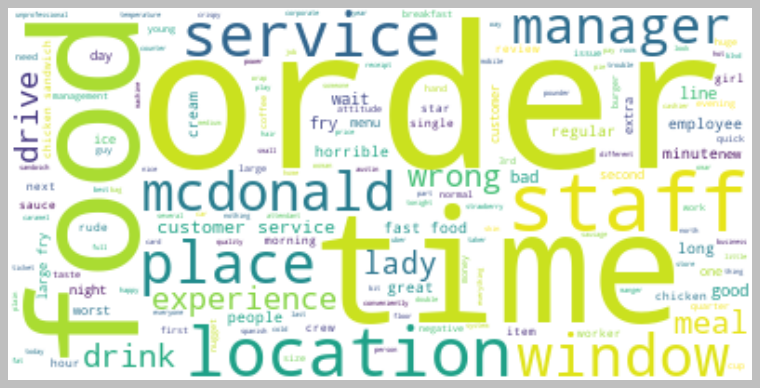

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_prc['sub_aspect'].values
for i in range(df_prc.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

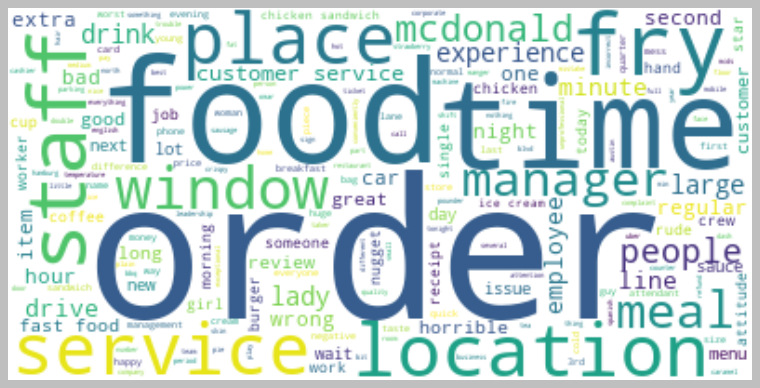

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
sub_aspect = df_st['sub_aspect'].values
for i in range(df_st.shape[0]):
    text = text + " " + " ".join(list(sub_aspect[i]))
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Get Topic

In [38]:
texts.apply(lambda x: " ".join(x))

0     someone spit food normal transaction everyone ...
1     food staff difference friendly accommodate smi...
2     mobile order speaker line late work refund mon...
3        crispy chicken sandwich customer service quick
4     repeat order time drive thru large meal double...
                            ...                        
95    negative star location absolute single time or...
96    order food employee microphone mess food order...
97    review place location rude service order wrong...
98                                  allways cream world
99    mcdonalds great people english spanish spanish...
Name: token_clean, Length: 100, dtype: object

In [36]:
df_prc['token_clean'].values

array(['why do it look like someone spit on my food . i have a normal transaction , everyone be chill and polite , but now i dont want to eat this . im try not to think about what this milky white or clear substance be all over my food , i d sure be not come back .',
       'it would mcdonalds . it be what it be as far as the food and atmosphere go . the staff here do make a difference . they be all friendly , accommodate and always smile . make for a more pleasant experience than many other fast food place .',
       'make a mobile order get to the speaker and check it in line be not move so i have to leave otherwise id be late for work never get the refund in the app i call them and they say i could only get my money back in person because it be stick in the system went there in person the next day and the manager tell me she wasn',
       'my mc . crispy chicken sandwich be customer service be quick and p',
       'i repeat my order 3 time in the drive thru , and she still manage to

In [52]:
import gensim

texts = df_prc['token_clean'].apply(util.preprocess_lda)

dictionary = gensim.corpora.Dictionary(texts)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)

bow_corpus = [dictionary.doc2bow(doc) for doc in texts]

bow_doc_25 = bow_corpus[25]
for i in range(len(bow_doc_25)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_25[i][0], 
                                               dictionary[bow_doc_25[i][0]], 
                                                     bow_doc_25[i][1]))
print(bow_doc_25)

0 clear
1 everyone
2 food
3 milky
4 normal
5 polite
6 someone
7 spit
8 substance
9 transaction
10 white
Word 4 ("drive") appears 1 time.
[(4, 1)]


In [48]:
from gensim import corpora, models
from pprint import pprint

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 1.0)]


In [49]:
# LDA using BoW

lda_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=10,
                                    id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.471*"food" + 0.231*"drive" + 0.201*"order" + 0.071*"thru" + 0.007*"time" + 0.007*"service" + 0.007*"location" + 0.006*"staff"
Topic: 1 
Words: 0.345*"time" + 0.336*"order" + 0.124*"drive" + 0.092*"staff" + 0.052*"thru" + 0.020*"service" + 0.016*"location" + 0.014*"food"
Topic: 2 
Words: 0.549*"order" + 0.160*"drive" + 0.160*"thru" + 0.077*"food" + 0.031*"location" + 0.008*"time" + 0.008*"service" + 0.008*"staff"
Topic: 3 
Words: 0.392*"service" + 0.192*"food" + 0.189*"staff" + 0.070*"time" + 0.061*"drive" + 0.056*"location" + 0.021*"order" + 0.020*"thru"
Topic: 4 
Words: 0.552*"order" + 0.132*"food" + 0.120*"time" + 0.113*"location" + 0.038*"drive" + 0.034*"service" + 0.009*"staff" + 0.001*"thru"
Topic: 5 
Words: 0.310*"thru" + 0.304*"drive" + 0.222*"staff" + 0.143*"order" + 0.005*"food" + 0.005*"time" + 0.005*"service" + 0.005*"location"
Topic: 6 
Words: 0.463*"order" + 0.279*"service" + 0.145*"location" + 0.037*"drive" + 0.036*"time" + 0.030*"food" + 0.006*"thru" +

In [50]:
lda_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10,
                                      id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.259*"staff" + 0.217*"time" + 0.152*"service" + 0.123*"thru" + 0.120*"drive" + 0.063*"order" + 0.048*"food" + 0.017*"location"
Topic: 1 Word: 0.514*"time" + 0.304*"staff" + 0.053*"location" + 0.043*"food" + 0.032*"thru" + 0.025*"order" + 0.021*"drive" + 0.007*"service"
Topic: 2 Word: 0.603*"order" + 0.110*"staff" + 0.106*"time" + 0.059*"thru" + 0.057*"drive" + 0.028*"service" + 0.026*"food" + 0.013*"location"
Topic: 3 Word: 0.532*"service" + 0.139*"food" + 0.136*"order" + 0.085*"location" + 0.046*"staff" + 0.028*"drive" + 0.020*"thru" + 0.013*"time"
Topic: 4 Word: 0.352*"location" + 0.249*"food" + 0.162*"drive" + 0.106*"order" + 0.061*"thru" + 0.037*"time" + 0.028*"service" + 0.005*"staff"
Topic: 5 Word: 0.649*"food" + 0.206*"order" + 0.074*"staff" + 0.021*"thru" + 0.020*"time" + 0.016*"drive" + 0.007*"location" + 0.007*"service"
Topic: 6 Word: 0.565*"thru" + 0.319*"drive" + 0.019*"time" + 0.019*"order" + 0.019*"food" + 0.019*"service" + 0.019*"location" + 0.019*"staff"

In [57]:
sorted(lda_bow[bow_doc_25], key=lambda tup: -1*tup[1])

[(8, 0.54990965),
 (5, 0.05002739),
 (0, 0.05001966),
 (2, 0.050012287),
 (1, 0.050011262),
 (9, 0.05001075),
 (3, 0.050004374),
 (4, 0.05000303),
 (6, 0.05000157),
 (7, 0.05000003)]

In [60]:
# Test LDA BoW

print(texts[25])
for idx, score in sorted(lda_bow[bow_doc_25], key=lambda tup: -1*tup[1]):
    print(f"\nScore: {score}\t \nTopic: {lda_bow.print_topic(idx, 10)}")

['mcdonalds', 'broken', 'cream', 'machine', 'planet', 'drive', 'lady']

Score: 0.5499271154403687	 
Topic: 0.310*"thru" + 0.304*"drive" + 0.222*"staff" + 0.143*"order" + 0.005*"food" + 0.005*"time" + 0.005*"service" + 0.005*"location"

Score: 0.050019972026348114	 
Topic: 0.253*"location" + 0.252*"drive" + 0.221*"order" + 0.120*"thru" + 0.073*"food" + 0.042*"time" + 0.036*"service" + 0.003*"staff"

Score: 0.05001651123166084	 
Topic: 0.471*"food" + 0.231*"drive" + 0.201*"order" + 0.071*"thru" + 0.007*"time" + 0.007*"service" + 0.007*"location" + 0.006*"staff"

Score: 0.0500103160738945	 
Topic: 0.549*"order" + 0.160*"drive" + 0.160*"thru" + 0.077*"food" + 0.031*"location" + 0.008*"time" + 0.008*"service" + 0.008*"staff"

Score: 0.050009455531835556	 
Topic: 0.345*"time" + 0.336*"order" + 0.124*"drive" + 0.092*"staff" + 0.052*"thru" + 0.020*"service" + 0.016*"location" + 0.014*"food"

Score: 0.050009023398160934	 
Topic: 0.200*"food" + 0.200*"thru" + 0.163*"order" + 0.163*"drive" + 0.08

In [61]:
# Test LDA BoW

print(texts[25])
for idx, score in sorted(lda_tfidf[bow_doc_25], key=lambda tup: -1*tup[1]):
    print(f"\nScore: {score}\t \nTopic: {lda_tfidf.print_topic(idx, 10)}")

['mcdonalds', 'broken', 'cream', 'machine', 'planet', 'drive', 'lady']

Score: 0.5499569773674011	 
Topic: 0.447*"drive" + 0.262*"service" + 0.113*"time" + 0.069*"order" + 0.042*"staff" + 0.037*"food" + 0.015*"location" + 0.015*"thru"

Score: 0.05001435801386833	 
Topic: 0.565*"thru" + 0.319*"drive" + 0.019*"time" + 0.019*"order" + 0.019*"food" + 0.019*"service" + 0.019*"location" + 0.019*"staff"

Score: 0.05001383647322655	 
Topic: 0.356*"order" + 0.269*"drive" + 0.173*"thru" + 0.104*"time" + 0.035*"location" + 0.034*"service" + 0.018*"staff" + 0.012*"food"

Score: 0.050007883459329605	 
Topic: 0.352*"location" + 0.249*"food" + 0.162*"drive" + 0.106*"order" + 0.061*"thru" + 0.037*"time" + 0.028*"service" + 0.005*"staff"

Score: 0.05000428110361099	 
Topic: 0.259*"staff" + 0.217*"time" + 0.152*"service" + 0.123*"thru" + 0.120*"drive" + 0.063*"order" + 0.048*"food" + 0.017*"location"

Score: 0.050001997500658035	 
Topic: 0.603*"order" + 0.110*"staff" + 0.106*"time" + 0.059*"thru" + 0.05

In [39]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(stop_words='english',
#                              max_df=.1, max_features=5000)
# texts = df_prc['token_clean'].apply(util.preprocess_lda)
# # X = vectorizer.fit_transform(df_prc['token_clean'].values)
# X = vectorizer.fit_transform(texts.apply(lambda x: " ".join(x)).values)

In [40]:
# from sklearn.decomposition import LatentDirichletAllocation

# # Define LatentDirichletAllocation with specified parameters
# lda = LatentDirichletAllocation(n_components=10, random_state=123, 
#                                 learning_method='batch')

# # Fit and transform the data using LDA
# X_topics = lda.fit_transform(X)


In [41]:
# n_top_words = 5
# feature_names = vectorizer.get_feature_names_out()

# # Iterate over each topic and print the top words
# for topic_idx, topic in enumerate(lda.components_):
#     print("Topic %d:" % (topic_idx + 1))
#     print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 1:
customer night extra wait sign
Topic 2:
great lady hour counter large
Topic 3:
wait receipt drink mcdonald employee
Topic 4:
person fast today sure sandwich
Topic 5:
chicken sandwich burger issue deluxe
Topic 6:
attendant rude unprofessional item quick
Topic 7:
correct spanish year meal home
Topic 8:
hour meal open mcdonald employee
Topic 9:
large lady experience regular miss
Topic 10:
great drink mcdonalds cream english


In [32]:
n_top_words = 5
feature_names = vectorizer.get_feature_names_out()

# Iterate over each topic and print the top words
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))


Topic 1:
large chicken sandwich ice drink
Topic 2:
hour day taste 24 sit
Topic 3:
lady correct miss work second
Topic 4:
burger eat drink sit regular
Topic 5:
work attitude quick answer cream
Topic 6:
night meal sauce long extra
Topic 7:
experience receipt employee rude want
Topic 8:
customer great look regular small
Topic 9:
nice star item plain kitchen
Topic 10:
rude nice 3rd friendly didnt


In [26]:
# from sklearn.feature_extraction.text import CountVectorizer

# texts = df_prc['token_clean'].values

# # Vectorizer the texts using CountVectorizer
# vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

# optimal_model, vectorizer = models.get_opt_lda_model(texts, vectorizer)

In [24]:
# # Print the topics
# def print_topics(model, vectorizer, num_words=10):
#     topics = model.components_
#     feature_names = vectorizer.get_feature_names_out()
#     for idx, topic in enumerate(topics):
#         print(f"Topic {idx + 1}:")
#         print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
#         print([topic.argsort()[:-num_words - 1: -1]])

# print_topics(optimal_model, vectorizer)

Topic 1:
['order', 'food', 'location', 'time', 'staff', 'service', 'wrong', 'sure', 'people', 'drink']
[array([356, 194, 288, 528, 484, 447, 572, 503, 367, 147], dtype=int64)]
Topic 2:
['order', 'food', 'drive', 'time', 'window', 'service', 'good', 'wait', 'minute', 'customer']
[array([356, 194, 148, 528, 564, 447, 213, 554, 321, 111], dtype=int64)]
Topic 3:
['order', 'time', 'lady', 'drive', 'window', 'regular', 'thru', 'staff', 'large', 'coffee']
[array([356, 528, 266, 148, 564, 415, 525, 484, 270,  75], dtype=int64)]
